# HomeWork 3 - Time Series
### Submitted by Jocelyn Prince

### Instructions
1. Choose one metric using Quandl services and data
2. Create examples of size 50
3. Split into train and test set
4. Try 2 of the RNN/CNN methods for time series forecasting that were demonstrated in class

#### Inspired by https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

-----

# 0. Import Libraries

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import optimizers

In [0]:
import quandl

In [0]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.metrics import mean_squared_error

# 1. Import Quandl Dataset from Quandl and Explore Data

LSTMs consume input in format [ batch_size, time_steps, Features ]; a 3- dimensional array.

Time Steps define how many units back in time the network will see. For example if we are working on a character prediction problem where you have a text corpus to train on and you decide to feed your network 6 characters at a time. Then your time step is 6. In our case we will be using 50 as time step.

Batch Size says how many samples of input do you want your Neural Net to see before updating the weights. So let’s say you have 100 samples (input dataset) and you want to update weights every time your NN has seen an input. In that case batch size would be 1 and total number of batches would be 100. Like wise if you wanted your network to update weights after it has seen all the samples, batch size would be 100 and number of batches would be 1. As it turns out using very small batch size reduces the speed of training and on the other hand using too big batch size (like whole dataset) reduces the models ability to generalize to different data and it also consumes more memory. But it takes fewer steps to find the minima for your objective function.

Features is the number of attributes used to represent each time step. Consider the character prediction example above, and assume that you use a one-hot encoded vector of size 100 to represent each character. Then feature size here is 2: "Adj. Close", "Adj. Volume".

In [0]:
df = quandl.get("WIKI/GE")

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14155 entries, 1962-01-02 to 2018-03-27
Data columns (total 12 columns):
Open           14155 non-null float64
High           14155 non-null float64
Low            14155 non-null float64
Close          14155 non-null float64
Volume         14155 non-null float64
Ex-Dividend    14155 non-null float64
Split Ratio    14155 non-null float64
Adj. Open      14155 non-null float64
Adj. High      14155 non-null float64
Adj. Low       14155 non-null float64
Adj. Close     14155 non-null float64
Adj. Volume    14155 non-null float64
dtypes: float64(12)
memory usage: 1.4 MB


In [0]:
df['Adj. Close']

Date
1962-01-02     0.328407
1962-01-03     0.325112
1962-01-04     0.321290
1962-01-05     0.313030
1962-01-08     0.312503
                ...    
2018-03-21    13.880000
2018-03-22    13.350000
2018-03-23    13.070000
2018-03-26    12.890000
2018-03-27    13.440000
Name: Adj. Close, Length: 14155, dtype: float64

In [0]:
df.describe()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
count,14155.000000,14155.000000,14155.000000,14155.000000,1.415500e+04,14155.000000,14155.000000,14155.000000,14155.000000,14155.000000,14155.000000,1.415500e+04
mean,58.273715,58.816780,57.731460,58.285165,1.463287e+07,0.002617,1.000495,8.629880,8.716514,8.537913,8.628655,2.046721e+07
std,27.591784,27.843127,27.363276,27.616519,3.028229e+07,0.031204,0.025211,10.036244,10.134135,9.934439,10.036164,2.855137e+07
min,6.750000,7.170000,5.727900,6.660000,0.000000e+00,0.000000,1.000000,0.243834,0.247700,0.238342,0.243834,0.000000e+00
25%,35.010000,35.310000,34.690000,35.000000,8.490000e+04,0.000000,1.000000,0.477739,0.481078,0.474224,0.477739,4.459200e+06
50%,55.250000,55.750000,54.750000,55.250000,1.140000e+06,0.000000,1.000000,2.236418,2.258210,2.211970,2.237398,1.295880e+07
75%,77.500000,78.120000,76.870000,77.500000,2.027685e+07,0.000000,1.000000,17.758441,17.979292,17.575476,17.773088,2.412225e+07
max,166.130000,167.940000,161.310000,166.000000,7.529044e+08,0.720000,3.000000,34.796446,35.297818,34.679376,35.006100,7.529044e+08


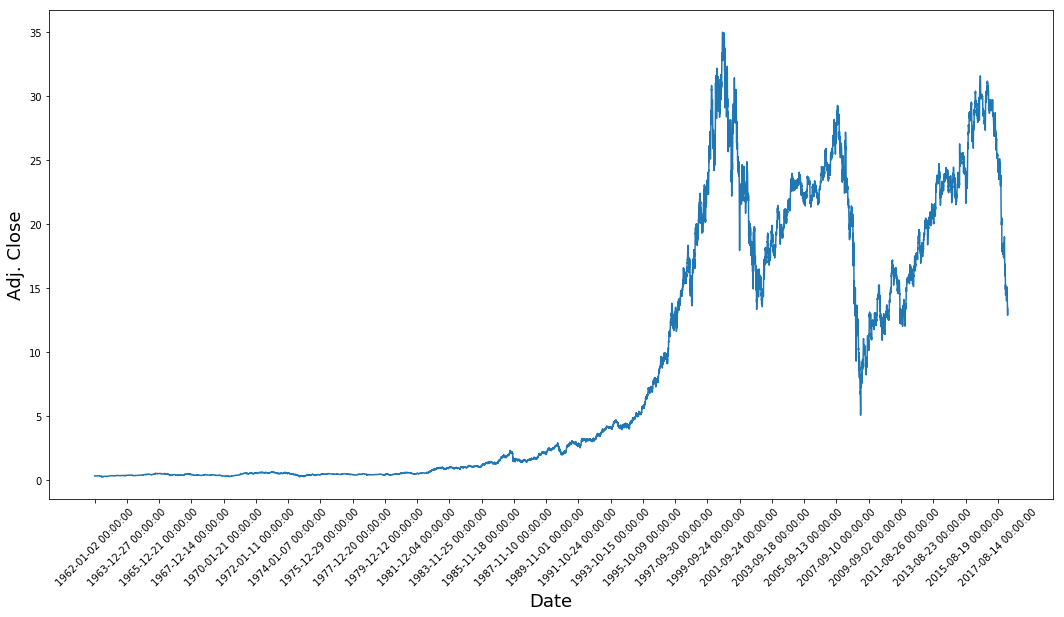

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Adj. Close']))
plt.xticks(range(0,df.shape[0],500),df.index[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Adj. Close',fontsize=18)
plt.show()

# 2. Create examples of 50 steps and Split Train/Test Dataset

In [0]:
# Train/Test data Split
train_cols = ["Adj. Close"]
df_train, df_test = train_test_split(df, 
                                     train_size=0.8, 
                                     test_size=0.2, 
                                     shuffle=False)
print("Train and Test size: ", len(df_train), len(df_test))

Train and Test size:  11324 2831


In [0]:
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(x)
X_test = min_max_scaler.transform(df_test.loc[:,train_cols])

In [0]:
print(type(X_train))
print(X_train.shape)

<class 'numpy.ndarray'>
(11324, 1)


In [0]:
print(type(X_test))
print(X_test.shape)

<class 'numpy.ndarray'>
(2831, 1)


In [0]:
print(X_train[-1, 0])

0.7281237766632489


In [0]:
print(X_train)

[[0.0024329 ]
 [0.00233811]
 [0.00222815]
 ...
 [0.73397952]
 [0.73203721]
 [0.72812378]]


In [0]:
print(X_train[:, 0])

[0.0024329  0.00233811 0.00222815 ... 0.73397952 0.73203721 0.72812378]


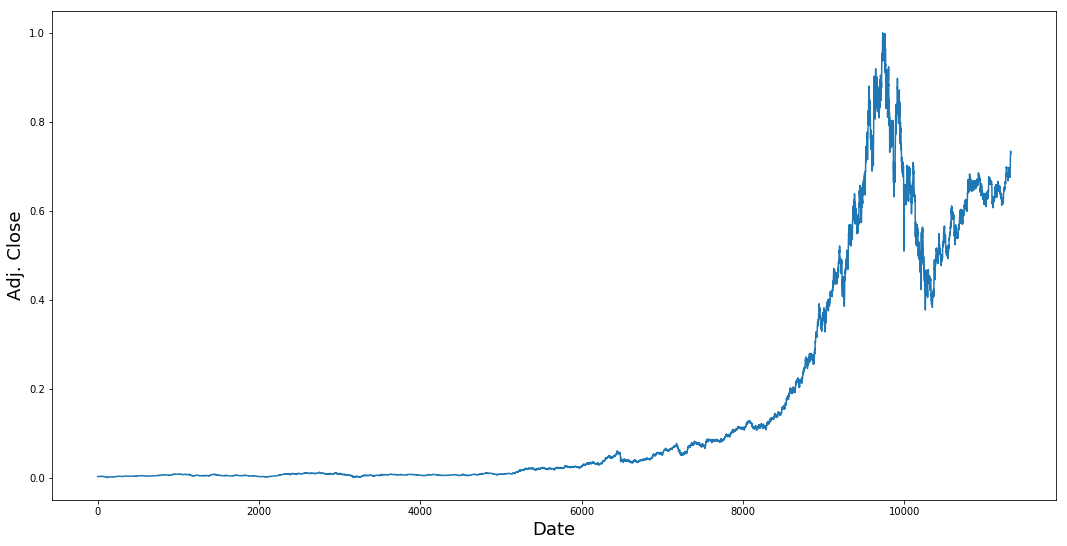

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(X_train.shape[0]),(X_train[:, 0]))
plt.xlabel('Date',fontsize=18)
plt.ylabel('Adj. Close',fontsize=18)
plt.show()

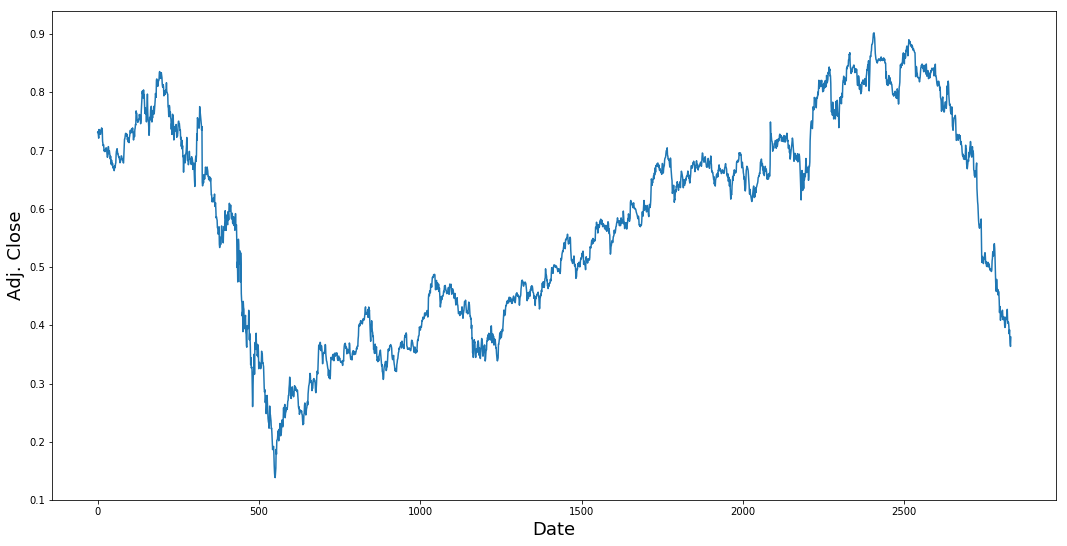

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(X_test.shape[0]),(X_test[:, 0]))
plt.xlabel('Date',fontsize=18)
plt.ylabel('Adj. Close',fontsize=18)
plt.show()

# 3. Functions

In [0]:
def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    Inspired by https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944
    """
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [0]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    Inspired by https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

# 4. LSTM Model : One Feature: "Adj. Close"

## 4.1 LSTM Model : Preparing Data

In [0]:
# Setup Parameters
TIME_STEPS = 50
BATCH_SIZE = 20
lr = 0.0001  # Learning Rate

In [0]:
x_t, y_t = build_timeseries(X_train, 0)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(X_test, 0)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)


length of time-series i/o (11274, 50, 2) (11274,)



length of time-series i/o (2781, 50, 2) (2781,)


In [0]:
print(x_t.shape)

(11260, 50, 2)


In [0]:
print(y_t.shape)

(11260,)


In [0]:
print(x_temp.shape)

(2781, 50, 2)


In [0]:
print(x_val.shape)

(1390, 50, 2)


In [0]:
print(x_test_t.shape)

(1390, 50, 2)


In [0]:
print(y_test_t.shape)

(1390,)


## 4.2 Create LSTM Model: One Feature

In [0]:
print(x_t.shape[2])

2


In [0]:
lstm_model = Sequential()
lstm_model.add(LSTM(128, 
                    batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), 
                    dropout=0.0, 
                    recurrent_dropout=0.0, 
                    stateful=True, 
                    #return_sequences = True,
                    kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
# lstm_model.add(LSTM(64, dropout=0.0))
# lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='relu'))
optimizer = optimizers.RMSprop(lr=lr)
lstm_model.compile(loss='mean_squared_error', 
                   optimizer=optimizer)

In [0]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (20, 128)                 67072     
_________________________________________________________________
dropout_2 (Dropout)          (20, 128)                 0         
_________________________________________________________________
dense_6 (Dense)              (20, 20)                  2580      
_________________________________________________________________
dense_7 (Dense)              (20, 1)                   21        
Total params: 69,673
Trainable params: 69,673
Non-trainable params: 0
_________________________________________________________________


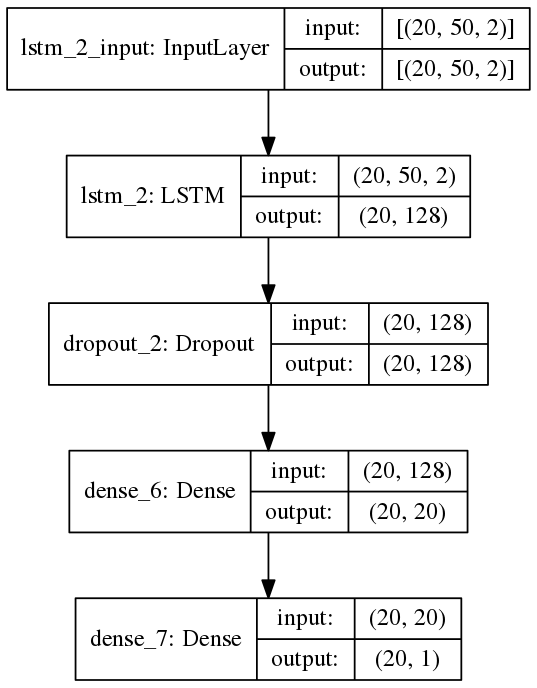

In [0]:
keras.utils.plot_model(lstm_model, to_file='model.png',show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=128)

## 4.3 Execute LSTM Model: One Feature

In [0]:
t1 = time.time()

hist = lstm_model.fit(x_t, 
                      y_t, 
                      epochs=60, 
                      verbose=0, 
                      batch_size=BATCH_SIZE,
                      shuffle=False, 
                      validation_data=(trim_dataset(x_val, BATCH_SIZE),
                      trim_dataset(y_val, BATCH_SIZE))
                      )
                         
t2 = time.time()

In [0]:
print("Execution time: {0:5.1f} min for {1:3.0f} epochs".format((t2 - t1)/60, len(hist.epoch)))

Execution time:   2.6 min for  60 epochs


## 4.4 Visualize the history of your training

<function matplotlib.pyplot.show(*args, **kw)>

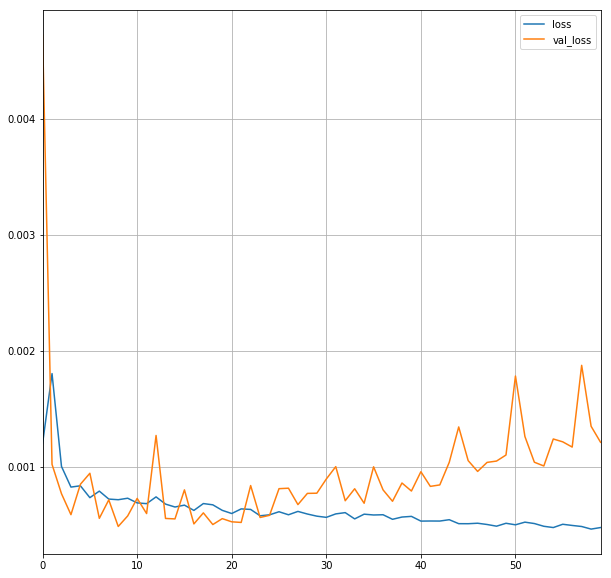

In [0]:
pd.DataFrame(hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

## 4.5. Evaluate the LSTM Model

In [0]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.001240282396194537 (1380,) (1380,)
[0.5181441  0.5207355  0.5237742  0.5244907  0.5254018  0.5275306
 0.5299944  0.5333491  0.53468925 0.5351638  0.5337291  0.53534615
 0.5384866  0.54141414 0.5441612 ]
[0.52543919 0.52761543 0.5261646  0.53075889 0.53535317 0.53946385
 0.54190022 0.53775839 0.5365402  0.53142382 0.54677297 0.54628569
 0.54872206 0.54823479 0.55115843]


In [0]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[18.255695 18.34578  18.45141  18.476318 18.507988 18.581991 18.66764
 18.784256 18.830843 18.84734  18.797464 18.853678 18.962847 19.064615
 19.160109]
[18.50929086 18.58494191 18.53450788 18.69421566 18.85392343 18.99681987
 19.08151367 18.9375342  18.8951873  18.71733032 19.25090127 19.23396251
 19.31865632 19.30171755 19.40335012]


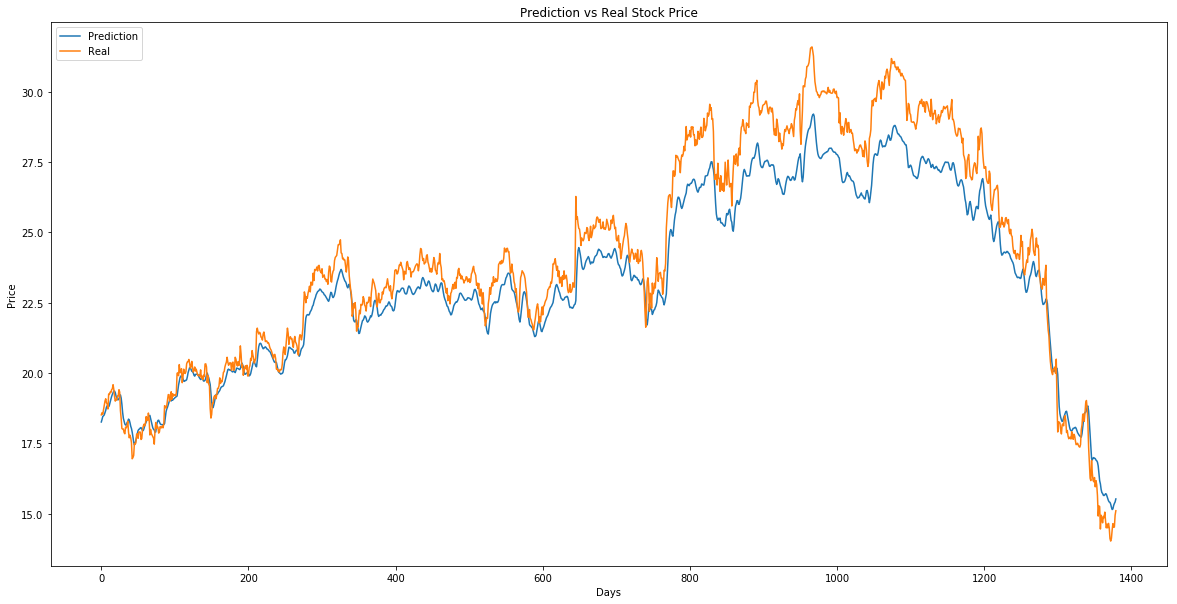

In [0]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
#plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
#print_time("program completed ", stime)

# 5. CONV 1D Model

## 5.1 CONV1D Model : Preparing Data

In [0]:
# Setup Parameters
TIME_STEPS = 50
BATCH_SIZE = 20
# lr = 0.0001  # Learning Rate

In [0]:
x_t, y_t = build_timeseries(X_train, 0)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(X_test, 0)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)


length of time-series i/o (11274, 50, 2) (11274,)



length of time-series i/o (2781, 50, 2) (2781,)


In [0]:
print(x_t.shape)

(11260, 50, 2)


In [0]:
print(y_t.shape)

(11260,)


In [0]:
print(x_temp.shape)

(2781, 50, 2)


In [0]:
print(x_val.shape)

(1390, 50, 2)


In [0]:
print(x_test_t.shape)

(1390, 50, 2)


In [0]:
print(y_test_t.shape)

(1390,)


## 5.2 Create CONV1D Model

In [0]:
conv1d_model = Sequential()

conv1d_model.add(layers.Conv1D(
    25, 
    4, 
    activation='relu', 
    input_shape=(None, x_t.shape[2])))
conv1d_model.add(layers.MaxPooling1D(2))
conv1d_model.add(layers.Conv1D(
    50, 
    4, 
    activation='relu'))
conv1d_model.add(layers.MaxPooling1D(2))
conv1d_model.add(layers.Conv1D(
    75, 
    4, 
    activation='relu'))
conv1d_model.add(layers.GlobalMaxPooling1D())
conv1d_model.add(layers.Dense(1))




In [0]:
conv1d_model.compile(loss="mse", optimizer="adam", 
                     #metrics=[last_time_step_mse]
             )

## 5.3 Execute CONV1D Model

In [0]:
t1 = time.time()

history_conv = conv1d_model.fit(x_t, 
                    y_t,
                    epochs=80,
                    verbose=0,
                    validation_data=(trim_dataset(x_val, BATCH_SIZE),
                      trim_dataset(y_val, BATCH_SIZE))
                   )

t2 = time.time()

In [0]:
print("Execution time: {0:5.1f} min for {1:3.0f} epochs".format((t2 - t1)/60, len(history_conv.epoch)))

Execution time:   1.5 min for  80 epochs


## 5.4. Visualize history of CONV1d Model

<function matplotlib.pyplot.show(*args, **kw)>

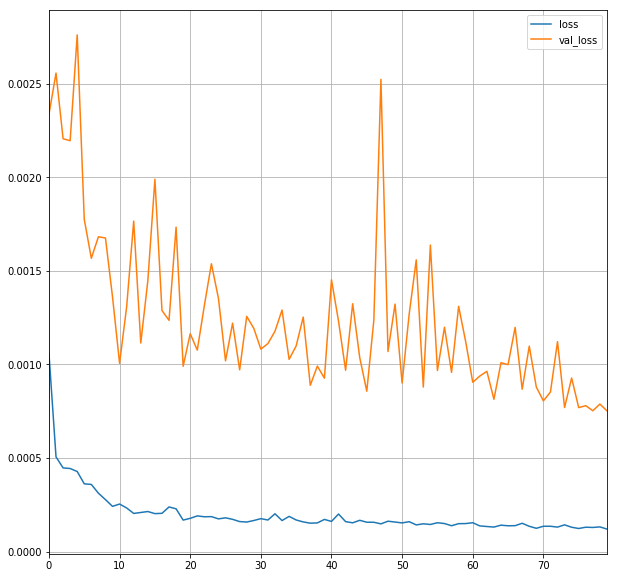

In [0]:
pd.DataFrame(history_conv.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

## 5.5. Evaluate the CONV1d Model

In [0]:
y_pred = conv1d_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.00044773829226773935 (1380,) (1380,)
[0.51621467 0.5223237  0.5239254  0.52479464 0.52320653 0.5299579
 0.52865374 0.53273267 0.53639346 0.5365466  0.53757507 0.5346226
 0.5324752  0.53188133 0.5391765 ]
[0.52543919 0.52761543 0.5261646  0.53075889 0.53535317 0.53946385
 0.54190022 0.53775839 0.5365402  0.53142382 0.54677297 0.54628569
 0.54872206 0.54823479 0.55115843]


In [0]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[18.188623 18.40099  18.456667 18.486883 18.431677 18.66637  18.621035
 18.762827 18.890085 18.895409 18.93116  18.828526 18.753876 18.733232
 18.98683 ]
[18.50929086 18.58494191 18.53450788 18.69421566 18.85392343 18.99681987
 19.08151367 18.9375342  18.8951873  18.71733032 19.25090127 19.23396251
 19.31865632 19.30171755 19.40335012]


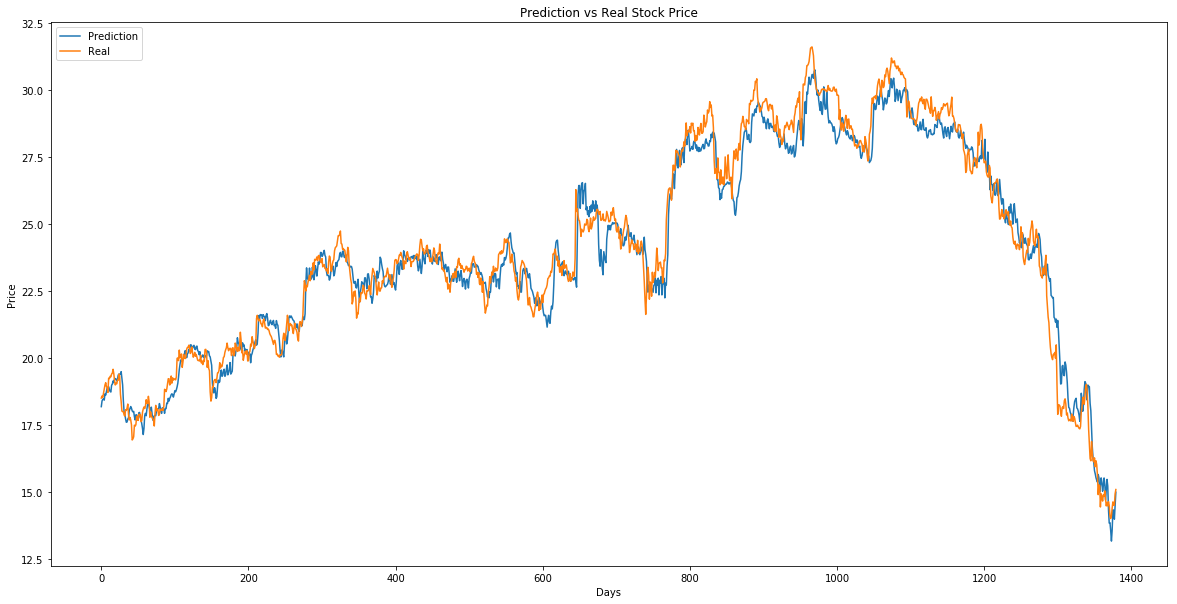

In [0]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
#plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
#print_time("program completed ", stime)

# 6. CONV1D Model : Two Features

## 6.1 Preparing data with two Features

In [0]:
# Train/Test data Split
train_cols = ["Adj. Close", "Adj. Open"]
df_train, df_test = train_test_split(df, 
                                     train_size=0.8, 
                                     test_size=0.2, 
                                     shuffle=False)
print("Train and Test size:", len(df_train), len(df_test))

Train and Test size: 11324 2831


In [0]:
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(x)
X_test = min_max_scaler.transform(df_test.loc[:,train_cols])

In [0]:
print(type(X_train))
print(X_train.shape)

<class 'numpy.ndarray'>
(11324, 2)


In [0]:
print(X_train[-1, 0])

0.7281237766632489


In [0]:
print(X_train)

[[0.0024329  0.00247945]
 [0.00233811 0.00240061]
 [0.00222815 0.0023523 ]
 ...
 [0.73397952 0.73804226]
 [0.73203721 0.74159731]
 [0.72812378 0.73884129]]


In [0]:
print(X_train[:, 0])

[0.0024329  0.00233811 0.00222815 ... 0.73397952 0.73203721 0.72812378]


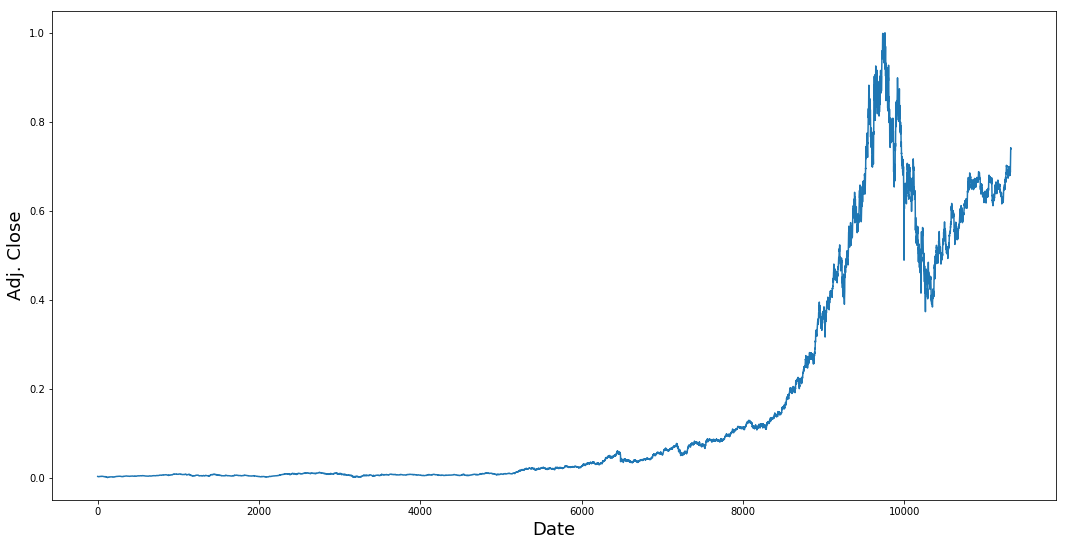

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(X_train.shape[0]),(X_train[:, 1]))
plt.xlabel('Date',fontsize=18)
plt.ylabel('Adj. Close',fontsize=18)
plt.show()

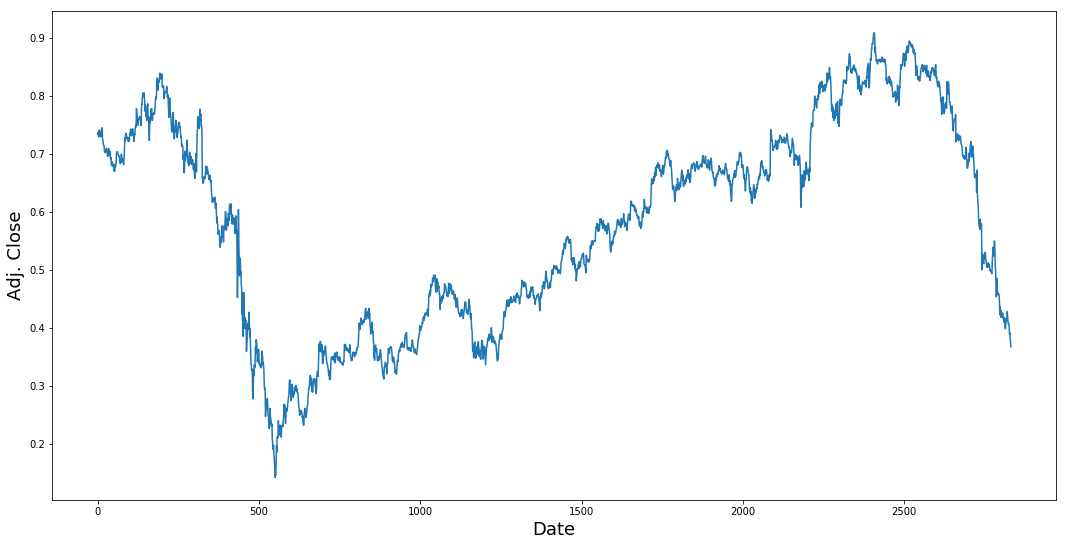

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(X_test.shape[0]),(X_test[:, 1]))
plt.xlabel('Date',fontsize=18)
plt.ylabel('Adj. Close',fontsize=18)
plt.show()

In [0]:
x_t, y_t = build_timeseries(X_train, 0)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(X_test, 0)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)


length of time-series i/o (11274, 50, 2) (11274,)



length of time-series i/o (2781, 50, 2) (2781,)


In [0]:
print(x_t.shape)

(11260, 50, 2)


In [0]:
print(y_t.shape)

(11260,)


In [0]:
print(x_temp.shape)

(2781, 50, 2)


In [0]:
print(x_val.shape)

(1390, 50, 2)


In [0]:
print(x_test_t.shape)

(1390, 50, 2)


In [0]:
print(y_test_t.shape)

(1390,)


## 6.2 Create CONV1D Model with Two Features

In [0]:
print(x_t.shape[2])

2


In [0]:
conv1d2_model = Sequential()

conv1d2_model.add(layers.Conv1D(
    25, 
    4, 
    activation='relu', 
    input_shape=(None, x_t.shape[2])))
conv1d2_model.add(layers.MaxPooling1D(2))
conv1d2_model.add(layers.Conv1D(
    50, 
    4, 
    activation='relu'))
conv1d2_model.add(layers.MaxPooling1D(2))
conv1d2_model.add(layers.Conv1D(
    75, 
    4, 
    activation='relu'))
conv1d2_model.add(layers.GlobalMaxPooling1D())
conv1d2_model.add(layers.Dense(1))




In [0]:
conv1d2_model.compile(loss="mse", optimizer="adam", 
                     #metrics=[last_time_step_mse]
             )

## 6.3 Execute Conv1D Model with two Features

In [0]:
t1 = time.time()

history_conv1d2 = conv1d2_model.fit(x_t, 
                    y_t,
                    epochs=80,
                    verbose=0,
                    validation_data=(trim_dataset(x_val, BATCH_SIZE),
                      trim_dataset(y_val, BATCH_SIZE))
                   )

t2 = time.time()

print("Execution time: {0:5.1f} min for {1:3.0f} epochs".format((t2 - t1)/60, len(history_conv1d2.epoch)))

Execution time:   1.5 min for  80 epochs


## 6.4 Visualize the history of your training

<function matplotlib.pyplot.show(*args, **kw)>

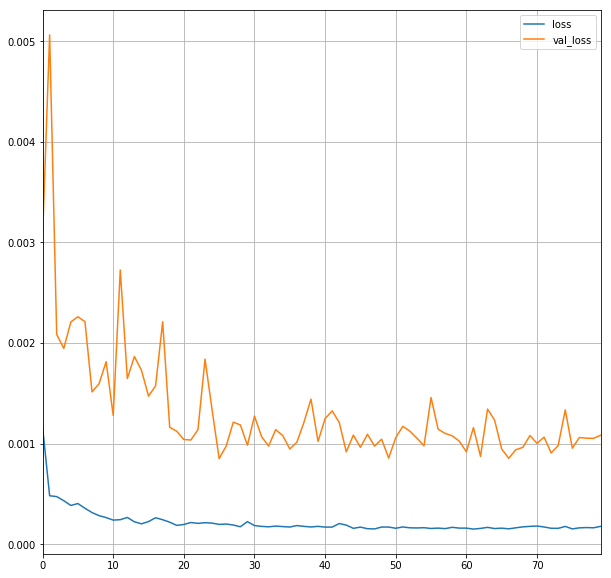

In [0]:
pd.DataFrame(history_conv1d2.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

## 6.5. Evaluate the Conv1d Model with 2 Features

In [0]:
y_pred = conv1d2_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.000660863002533368 (1380,) (1380,)
[0.51566756 0.5171842  0.5182768  0.52150464 0.5239394  0.52441376
 0.52556056 0.52877915 0.53473985 0.5352733  0.5375023  0.5375898
 0.53627497 0.5376773  0.53847957]
[0.52543919 0.52761543 0.5261646  0.53075889 0.53535317 0.53946385
 0.54190022 0.53775839 0.5365402  0.53142382 0.54677297 0.54628569
 0.54872206 0.54823479 0.55115843]


In [0]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[18.169605 18.222328 18.26031  18.372515 18.457153 18.473644 18.513508
 18.625395 18.832602 18.851147 18.92863  18.931671 18.885965 18.934713
 18.962603]
[18.50929086 18.58494191 18.53450788 18.69421566 18.85392343 18.99681987
 19.08151367 18.9375342  18.8951873  18.71733032 19.25090127 19.23396251
 19.31865632 19.30171755 19.40335012]


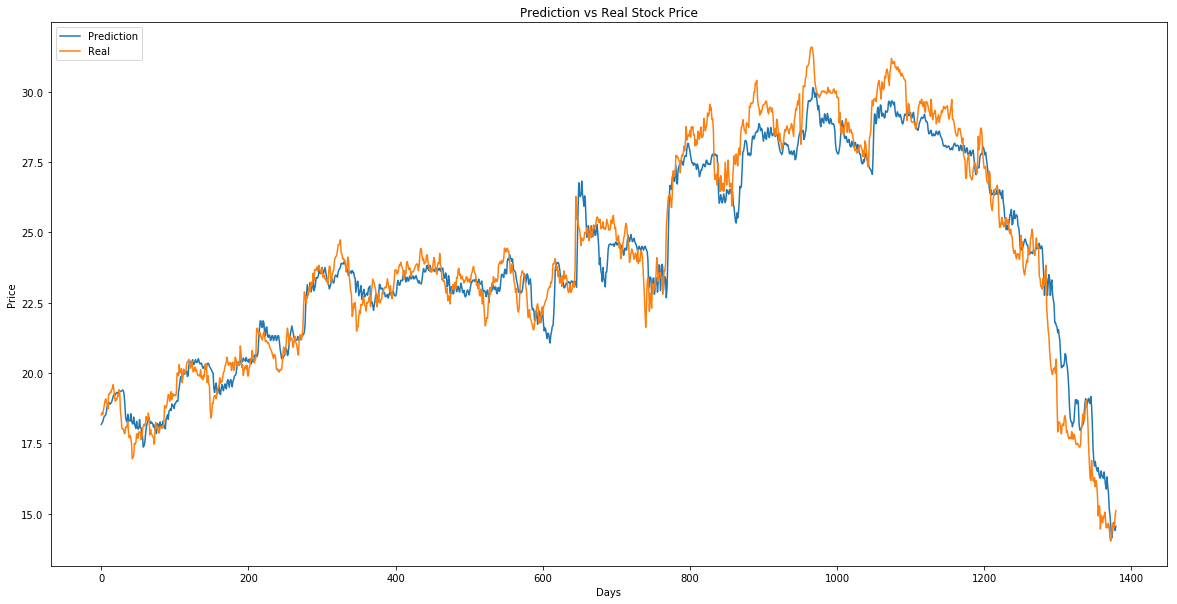

In [0]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
#plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
#print_time("program completed ", stime)